## 감정분석


# 데이터 불러오기

In [5]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ hash mecab
+ echo 'mecab-ko is already installed'
mecab-ko is already installed
+ [[ -d /usr/local/lib/mecab/dic/mecab-ko-dic ]]
+ echo 'mecab-ko-dic is already installed'
mecab-ko-dic is already installed
++ python3 -c 'import pkgutil; print(1 if pkgutil.find_loader("MeCab") else 0)'
+ [[ 1 == \1 ]]
+ echo 'mecab-python is already installed'
mecab-python is already installed
+ echo Done.
Done.


In [6]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
import pandas as pd
import numpy as np

# 구글드라이브로 불러오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
url = '/content/감정대화.xlsx'
df = pd.read_excel(url)

url2 = '/content/감정라벨.xlsx'
df2 = pd.read_excel(url2)

df

,감정,대화,label
0,신이 난,지금 난 기분이 너무 좋아.,23
1,신이 난,나도 조카가 생겨! 너무 기뻐.,23
2,불안,거래처와의 다음 계약이 무산될까봐 불안해.,45
3,염세적인,당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...,16
4,마비된,노년에 재정적으로 이루어 놓은게 없어서 걱정이야.,24
...,...,...,...
130216,느긋,부동산 임대 소득으로 현재 여유롭게 살 수 있어서 좋단다.,31
130217,회의적인,폐결핵은 이미 완치된 것 같은데 약을 한 달이나 더 먹으라고 하네? 아직 안 나은 ...,19
130218,좌절한,연애하고 싶은데 소개팅만 나가면 꽝이야. 이러다가 난 결혼 못 하고 늙어 죽을 거야.,20
130219,안달하는,은행 대출이 막혀서 생활비를 구할 수가 없어. 이제 어떻게 살아야 하나 막막해.,37


In [9]:
df2

,label,감정
0,0,혼란스러운
1,1,고립된
2,2,"가난한, 불우한"
3,3,상처
4,4,버려진
5,5,괴로워하는
6,6,걱정스러운
7,7,충격 받은
8,8,짜증내는
9,9,우울한


In [10]:
train = df.sample(frac=0.8, random_state=1)
test = df.drop(train.index)

# 데이터 정제
데이터에서 한글과 공백을 제외하고 모두 제거

In [11]:
train['대화'] = train['대화'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '')
train

,감정,대화,label
40996,혐오스러운,뉴스를 보았는데 이기적인 사람이 많은 것 같아,39
5401,질투하는,환갑 넘은 그 친구들이 돈이 많아 참 부럽고 질투나더라,10
8200,노여워하는,성적때문에 화가 치솟아,22
50802,좌절한,난 글렀어 우리 학교에 벌써 음반을 내서 돈을 버는 애도 있는데 난 뭔가 이룬게 없어,20
115618,좌절한,요즘 환절기라 감기 기운이 있어 안 그래도 코로나 때문에 불안한 시기인데 말이야,20
...,...,...,...
8001,우울한,건강 검진 결과가 나쁘게 나와서 우울해,9
77523,툴툴대는,은행에 가서 일을 보는데 너무 시간이 오래 걸렸어 짜증이 났네,17
6950,성가신,결혼 준비를 하는데 자꾸 친구가 참견하네,42
39294,고립된,나 어제 친구한테 고백했다가 차였어,1


In [12]:
train['대화'].replace('', np.nan, inplace = True)
print(len(train))
print(train.isnull().sum())

104177
감정       0
대화       0
label    0
dtype: int64


In [13]:
train = train.dropna(how = 'any')
print(len(train))

104177


In [14]:
test.drop_duplicates(subset=['대화'], inplace=True)
test['대화'] = test['대화'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '')
test['대화'].replace('', np.nan, inplace = True)
test = train.dropna(how = 'any')

# 토큰화 및 불용어 제거

단어들을 분리하고 불용어를 제거함

불용어 사전: '의', '가' , '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '을', '를', '으로','자', '에', '와', '한', '하다'

In [15]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
           '로써','으로써','에서','에게서','부터','까지','과','에서','을','로서','으로서','로','뭔','왠','웬','왠지']

In [16]:
from konlpy.tag import Mecab
mecab = Mecab()

X_train = []
for sentence in train['대화'] :
  X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [17]:
X_test = []
for sentence in train['대화'] :
  X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [18]:
torkenizer = Tokenizer()
torkenizer.fit_on_texts(X_train)
print(torkenizer.word_index)

{'어': 1, '하': 2, '나': 3, '고': 4, '는데': 5, '내': 6, '너무': 7, '친구': 8, '아': 9, '있': 10, '해': 11, '지': 12, '했': 13, '게': 14, '것': 15, '같': 16, '야': 17, '없': 18, '안': 19, '좋': 20, '었': 21, '않': 22, '일': 23, '만': 24, '네': 25, '해서': 26, '되': 27, '받': 28, '다': 29, '사람': 30, '았': 31, '어서': 32, '오늘': 33, '요즘': 34, '에게': 35, '보': 36, '회사': 37, '기': 38, '겠': 39, '돈': 40, '말': 41, '아서': 42, '님': 43, '건강': 44, '거': 45, '면': 46, '할': 47, '던': 48, '정말': 49, '걱정': 50, '다고': 51, '수': 52, '때문': 53, '싶': 54, '못': 55, '주': 56, '이번': 57, '생각': 58, '스러워': 59, '한테': 60, '우리': 61, '니': 62, '남편': 63, '아내': 64, '결혼': 65, '많이': 66, '힘들': 67, '직장': 68, '때': 69, '집': 70, '서': 71, '학교': 72, '라고': 73, '화': 74, '많': 75, '기분': 76, '적': 77, '나이': 78, '모르': 79, '돼': 80, '해야': 81, '아들': 82, '마음': 83, '준비': 84, '엄마': 85, '이제': 86, '살': 87, '가족': 88, '먹': 89, '남자': 90, '난': 91, '랑': 92, '부모': 93, '봐': 94, '취업': 95, '데': 96, '자꾸': 97, '더': 98, '당황': 99, '아이': 100, '자식': 101, '은퇴': 102, '날': 103, '알': 104, '인데': 105, '짜증': 10

# 빈도 수가 낮은 단어 제거
빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음

처리를 통해 빈도 수가 낮은 단어들은 제거

In [19]:
threshoid = 3
words_cnt = len(torkenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in torkenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshoid :
    rare_cnt += 1 
    rare_freq = rare_freq + value

print(words_cnt)
print("빈도가 {} 이하인 희귀단어 수 : {}".format(threshoid-1, rare_cnt))
print("희귀단어비율 : {}".format((rare_cnt / words_cnt) * 100))
print("희귀단어 등장빈도 비율 : {}".format((rare_freq / words_freq) * 100))

16122
빈도가 2 이하인 희귀단어 수 : 6499
희귀단어비율 : 40.311375759831286
희귀단어 등장빈도 비율 : 0.6962153935950934


In [20]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

9625


In [21]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

In [23]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

print(len(X_train))
print(len(y_train))

104176
104176


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩
전반적인 길이를 확인 모델의 입력을 위해 동일한 길이로 맞춰줌

In [24]:
print('최대 길이 : ', max(len(l) for l in X_train))
print('평균 길이 : ', sum(map(len, X_train)) / len(X_train))

최대 길이 :  63
평균 길이 :  12.564640608201506


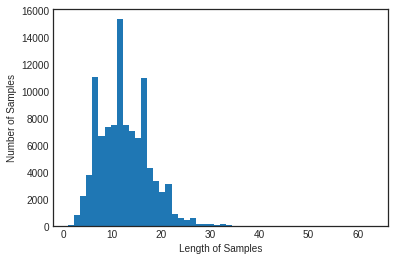

In [25]:
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [26]:
max_len = 60

In [27]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 구축 및 학습
감정 상태 분류 모델을 선언하고 학습 모델은 일반적인 LSTM 모델을 사용

In [28]:
from tensorflow.keras.layers import BatchNormalization, Embedding, Dense, LSTM, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential

In [35]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 128))
model3.add(LSTM(128))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(58, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])


model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1232000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 58)               

In [36]:
history3 = model3.fit(X_train, y_train, epochs=10, batch_size = 50, validation_split = 0.2)

Epoch 1/10
1667/1667 [==============================] - 252s 150ms/step - loss: 3.2492 - accuracy: 0.2102 - val_loss: 2.7867 - val_accuracy: 0.3219
Epoch 2/10
1667/1667 [==============================] - 250s 150ms/step - loss: 2.7082 - accuracy: 0.3398 - val_loss: 2.6393 - val_accuracy: 0.3562
Epoch 3/10
1667/1667 [==============================] - 249s 149ms/step - loss: 2.4890 - accuracy: 0.3874 - val_loss: 2.5846 - val_accuracy: 0.3682
Epoch 4/10
1667/1667 [==============================] - 250s 150ms/step - loss: 2.3208 - accuracy: 0.4255 - val_loss: 2.5587 - val_accuracy: 0.3848
Epoch 5/10
1667/1667 [==============================] - 249s 149ms/step - loss: 2.1791 - accuracy: 0.4581 - val_loss: 2.5800 - val_accuracy: 0.3952
Epoch 6/10
1667/1667 [==============================] - 248s 149ms/step - loss: 2.0599 - accuracy: 0.4848 - val_loss: 2.6137 - val_accuracy: 0.4024
Epoch 7/10
1667/1667 [==============================] - 249s 149ms/step - loss: 1.9524 - accuracy: 0.5085 - val_

In [37]:
model3.evaluate(X_test, y_test)

3256/3256 [==============================] - 75s 23ms/step - loss: 1.6955 - accuracy: 0.5916


[1.6954928636550903, 0.5915797352790833]

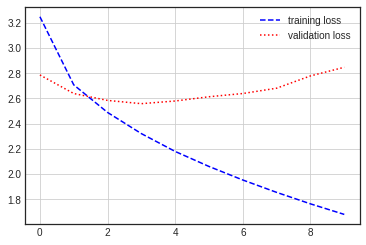

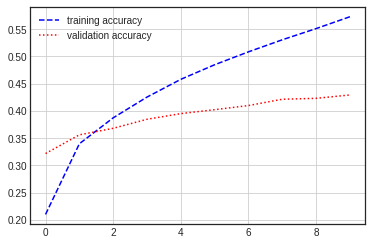

In [38]:
hist_dict = history3.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r:', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training accuracy')
plt.plot(val_acc, 'r:', label = 'validation accuracy')
plt.legend()
plt.grid()

plt.show()

In [50]:
def sentiment_predict(new_sentence) :
  new_token =[word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences = tokenizer.texts_to_sequences([new_token])
  new_pad = pad_sequences(new_sequences, maxlen = max_len)
  score = model3.predict(new_pad)

  result1 = pd.DataFrame(score).T

  df2['result'] = result1
  df3 = df2.sort_values(by="result", ascending=False)
  df3 = df3.reset_index()
  print("{} : {} - [{:.2f}%]".format(new_sentence, df3['감정'][0], (df3['result'][0]) * 100))

In [58]:
sentiment_predict('요즘 너무 외로워 연애하고 싶어')
sentiment_predict('배가 너무 아파')
sentiment_predict('너무 힘들어')
sentiment_predict('재미있어요')

요즘 너무 외로워 연애하고 싶어 : 외로운 - [41.94%]
배가 너무 아파 : 괴로워하는 - [7.15%]
너무 힘들어 : 괴로워하는 - [9.74%]
재미있어요 : 신이 난 - [31.09%]


In [55]:
sentiment_predict('게임에서 이겼어')
sentiment_predict('과제가 내일까지야')
sentiment_predict('내일 면접이야')
sentiment_predict('뭐 하나 사고 싶은데 돈이 부족해')
sentiment_predict('컴퓨터가 고장났어')

게임에서 이겼어 : 신이 난 - [60.52%]
과제가 내일까지야 : 초조한 - [12.20%]
내일 면접이야 : 걱정스러운 - [20.15%]
뭐 하나 사고 싶은데 돈이 부족해 : 가난한, 불우한 - [34.91%]
컴퓨터가 고장났어 : 혼란스러운 - [6.55%]


In [60]:
sentiment_predict('오늘 6시까지 프로젝트 제출인데 망한거 같아')
sentiment_predict('중요한건 끝난다고 바로 취업도 안될꺼 같은데')
sentiment_predict('뭐라는거야')
sentiment_predict('뭔 소리인지 모름')
sentiment_predict('안 들을래')
sentiment_predict('출근하기 싫다')
sentiment_predict('출근하고 싶다')
sentiment_predict('눈감고 돈벌고 싶다')

오늘 6시까지 프로젝트 제출인데 망한거 같아 : 좌절한 - [18.39%]
중요한건 끝난다고 바로 취업도 안될꺼 같은데 : 후회되는 - [7.48%]
뭐라는거야 : 혼란스러운 - [3.88%]
뭔 소리인지 모름 : 혼란스러운 - [4.14%]
안 들을래 : 염세적인 - [66.64%]
출근하기 싫다 : 염세적인 - [10.16%]
출근하고 싶다 : 회의적인 - [6.76%]
눈감고 돈벌고 싶다 : 우울한 - [20.65%]
